# Chapter 13 . Loading and Preprocessing Data with TensorFlow

## The Data API

##### dataset: this represent a sequence of data items.

**Create a dataset entirely in RAM usng** tf.data.Dataset.from\_tensor\_slices( )

In [2]:
import tensorflow as tf

In [3]:
X = tf.range(10) # any data tensor

In [20]:
dataset = tf.data.Dataset.from_tensor_slices(X)

In [5]:
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

**The** from\_tensor\_slices( ) **function takes a tensor and creates a** tf.data.Dataset **whose elements are all the slices of** X

* **We would have obtained the same dataset if we had used** tf.data.Dataset.range(10)

In [9]:
tf.data.Dataset.range(10)

<RangeDataset shapes: (), types: tf.int64>

* **You can simply iterate over a dataset's items like this:**

In [6]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### Chaining Transformations
* **Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods.**
    * **Each method returns a new dataset, so you can chain transformations like this**

In [23]:
dataset = dataset.repeat(3).batch(7,drop_remainder=True)

* **The** batch **method had to output a final batche of size two instead of seven, but you can call it with** drop\_remainder = True **if you want to drop this final batch so all batches have the exact same size.**

In [19]:
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)


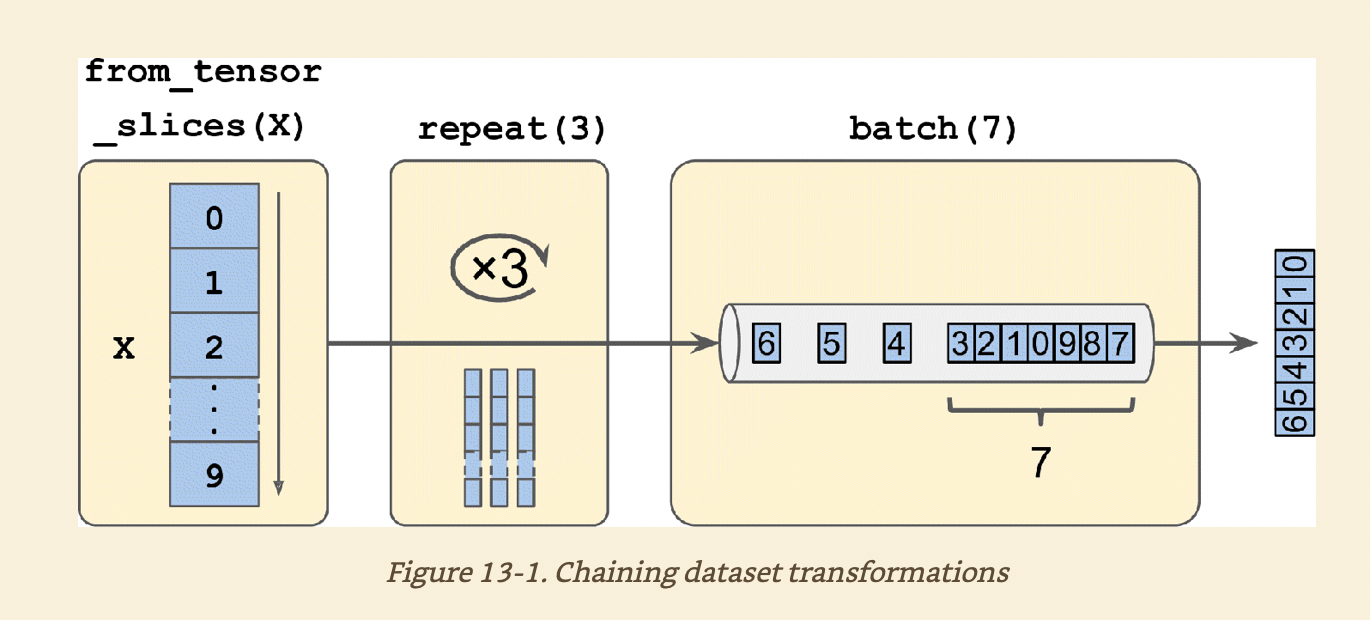
* **In this example, we first call the** repeat( ) **method on the original dataset, and it retuns a new dataset that will repeat the items of the original dataset** 3 **times.**
    * **if you call this method with no arguments, the new dataset will repeat the source dataset forever, so the code that iterates ober the dataset will have to decide when to stop.**
* **Then we call the** batch( ) **method on this new dataset, and again this creates a new dataset. This will group the items of the previous dataset in batches of seven times.**
* **Finally we iterate over the items of this final dataset.**

##### The dataset methods do not modify datasets, they create new ones, so make sure to keep a reference to these new datasets(e.g., with dataset = ...), or else nothing will happen


* **You can also transform the items by calling the** map( ) **method.**

In [21]:
dataset = dataset.map(lambda x: x * 2)

In [22]:
dataset

<MapDataset shapes: (), types: tf.int32>

* **This function is the one you will call to apply any preprocessing you want to your data.**
* **Sometimes this will include computations that can be quire intensive, so you will usually want to spawn multiple threads to speed things up: it's as simple as setting the** num\_parallel\_calls **argument.**
    * **The function you pass to the** map( ) **method must be convertible to a TF Function.**

##### map( ) vs. apply( )
* **While the** map( ) **method applies a transformaton to each item, the** apply( ) **method aplies a transformation to the dataset as a whole**

In [ ]:
dataset = dataset.apply(tf.data.experimental.unbatch())

* **It is also possible to simply filter the dataset using the** filter( ) **method**

In [30]:
dataset = dataset.filter(lambda x: x < 10)

* **To look a few items from the dataset, use the** take( ) **method**

In [32]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### Shuffling the Data
* **Ensure the training set are independent and identically distributed.**
    * **A simple way is to shuffle the instances, using the** shuffle( ) **method.It will create new dataset that will start by filling up a buffer with the first items of the source dataset.**
    * **Then, whenevr it is asked for an item, it will pull out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the dataset.**
    * **Until this point, it continues to pull out randomly from the buffer until it is empty.**
    * **You must specify the buffer size, and it is important ot make it large enough, or else shuffling will not be very effective.**
    * **You can provide a random seed if you want the same random order every time you run your program.**

**Creates and displays a dataset containing the integers 0 to 9, repeated 3 times, shuffles using a buffer of size 5 and a random seed of 42, and batched with a batch size of 7**

In [33]:
dataset = tf.data.Dataset.range(10).repeat(3) # 0 to 9, three times

In [34]:
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)

In [35]:
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


***If you call*** repeat( ) ***on a shuffled dataset, by default it will generate a new order at every iteration. If you prefer to resue the same order at each iteration, you can set*** reshuffle\_each\_iteration=False.

### Large Dataset
* **For a large dataset that does not fit in memory, the simple shuffling-buffer approach may not be sufficeint, since the buffer will be small compared to the dataset.**
    * **One solution is to shuffle the source data itself.**
    * **To shuffle the instances some more, a common aproach is to split the source data into multiple files, then read them in a random order during training.**
    * **Then pick multiple files randomly and read them simultaneousy, interleaving their records.**
    * **on top of that you can adda shuffling buffer using the** shuffle( ) **method.**

##### Data API makes all this possible in just a  few lines of code

### Interleaving lines from multiple files

**Load the california housing dataset, shuffled it, and split it into s traiing set, a validation set, and a test set**

In [36]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

**For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:**

In [37]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [41]:
import numpy as np
import os

In [42]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

**Look at one of the files**

In [43]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  3.5214      15.0  3.049945   1.106548      1447.0  1.605993     37.63   
1  5.3275       5.0  6.490060   0.991054      3464.0  3.443340     33.69   
2  3.1000      29.0  7.542373   1.591525      1328.0  2.250847     38.44   
3  7.1736      12.0  6.289003   0.997442      1054.0  2.695652     33.55   
4  2.0549      13.0  5.312457   1.085092      3297.0  2.244384     33.93   

   Longitude  MedianHouseValue  
0    -122.43             1.442  
1    -117.39             1.687  
2    -122.98             1.621  
3    -117.70             2.621  
4    -116.93             0.956

**Read the file in text mode.**

In [44]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


**Training file path contains a list of training file paths(and yu also have** valid\_filepaths **and** test\_filepaths **)**

In [45]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

**Create a dataset containing only these file paths**<br>
* **By default, the** list\_files( ) **function returns a dataset that shuffles the file paths.(You can set** shuffle=False **if you do not want that for some reason.)**


In [47]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

**Next, you can call the** interleave( ) **method to read from five files at a time and interleave their lines(skipping the first line of each file, which is the header row, using the** skip( ) **method):**

In [48]:
n_readers = 5
dataset = filepath_dataset.interleave(lambda filepath: 
                                     tf.data.TextLineDataset(filepath).skip(1),
                                     cycle_length=n_readers)

* **The** interleave( ) **method will create a dataset that will pull five paths from the** filepath\_dataset, **and for each one it will call the function you gave it( a lambda in this example) to create a new dataset(in this case a** TextLineDataset. **)**
* **To be clear, at this stage there will be seven datasets in all: the filepath dataset, the interleave dataset, and the five** TextLineDataset **created internally by the interleaving dataset.**
    * **When we iterate over the interleave dataset, it will cycle through these five** TextLineDatasets, **reading one line at a time from each until all datasets are out of items. Then it will get the next five file paths from the** filepath\_dataset **and interleave them the same way, and so on util it runs out of file paths**
* interleave( ) **does ot use parallelism; it just reads one line at a time from each file, sequentially. If you want it to acrually read files in parallel, you can set the** num\_parallel\_calls **argument to the number of threads you want**

**Let's look at what the dataset contains now**<br>
* **These are the firs rows of five CSV files, chosen randomly.**
* **These are just byte strings; we need to parse and scale the data.**

In [49]:
for line in dataset.take(5):
    print(line.numpy())

b'4.2083,44.0,5.323204419889502,0.9171270718232044,846.0,2.3370165745856353,37.47,-122.2,2.782'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442'


### Preprocessing the Data

* **Assumes that we have precomputed the mean and standard deviation of each feature in the training set.**
    * X\_mean **and** X\_std **are just 1D tensors(or NumPy arrays) containing eight floats, one per input feature.**

In [50]:
X_mean

array([ 3.89175860e+00,  2.86245478e+01,  5.45593655e+00,  1.09963474e+00,
        1.42428122e+03,  2.95886657e+00,  3.56464315e+01, -1.19584363e+02])

In [51]:
X_std

array([1.90927329e+00, 1.26409177e+01, 2.55038070e+00, 4.65460128e-01,
       1.09576000e+03, 2.36138048e+00, 2.13456672e+00, 2.00093304e+00])

In [52]:
n_inputs = 8

In [53]:
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

* **The** preprocess( ) **function takes one csv line and starts by parsing it. For this it uses the** tf.io.decode\_csv( ) **function, wich takes two arguments: the first is the line to parse, and the second is an array containing the default value for each column in the CSV file.**
    * **This array tells TensorFlow not only the default value for each column, but also the number of columns and their types.**
    * **The** decode\_csv( ) **function returns a list of scalar tensors(one per column), but we need to return 1D tensor array**
* **We call** tf.stack( ) **on all tensors except for the last one(the target): this will stack these tensors into a 1D array.**
* **We then do the same for the target value(this makes it a 1D tensor array with a single value, rather than a scaler tensor)**
* **Finally we scale the input features by subtracting the feature means and then dividing by the feature standard deviation.**
* **We return a tuple containng the scaled featueres and the target.**

In [61]:
for line in dataset.take(1):
    print(preprocess(line))

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 2.5288372 ,  1.216324  ,  0.27730897, -0.11517552, -0.69018877,
       -0.06940325, -0.6776224 ,  0.70185536], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.159], dtype=float32)>)


### Putting Everything Together
* **Create a helper function that will create and return a dataset that will efficiently load California housing data fro multiple CSV files, preprocess it, shuffle it, optionally repeat it, and batch it.**

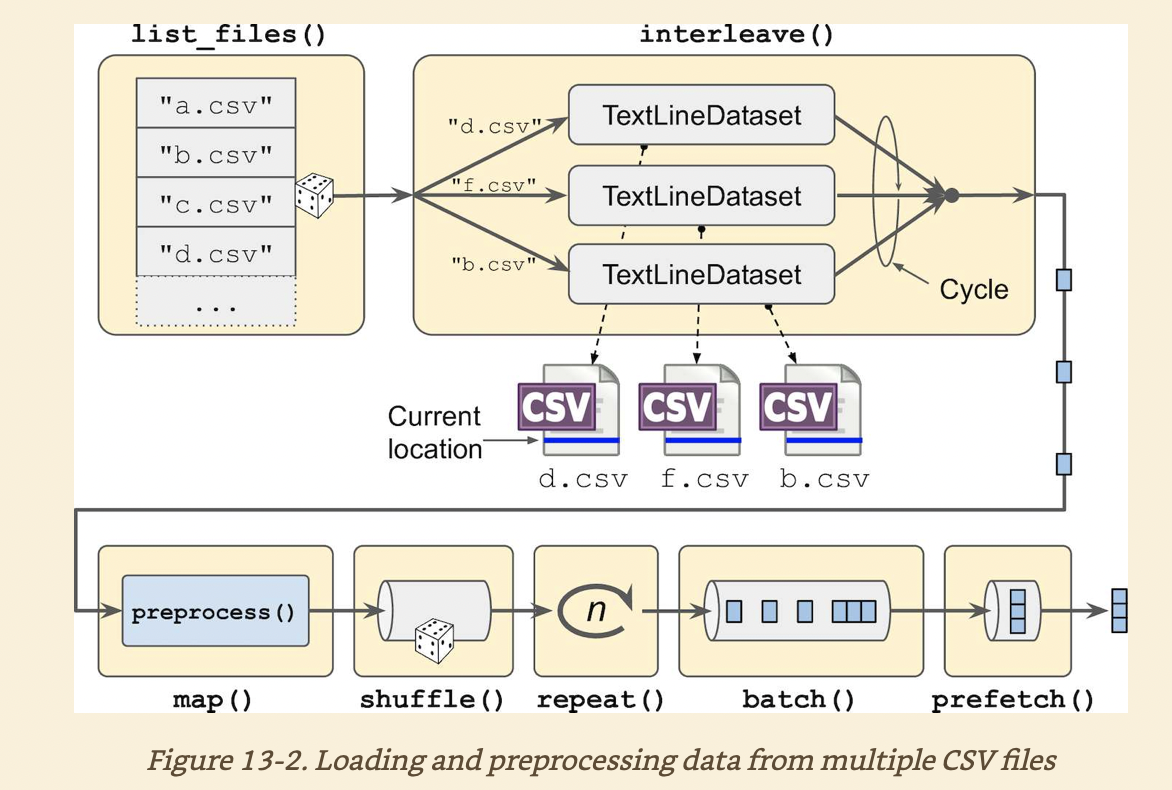

In [65]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

### Prefecthing
* **Calling** prefetch(1) **allow the dataset to be always one batch ahead. While the training alogirthm is working on one batch, the dataet will already by working in parallel on getting the next batch ready(e.g., reading the dat from disk and preprocessing it). This can inporve performance dramatically**
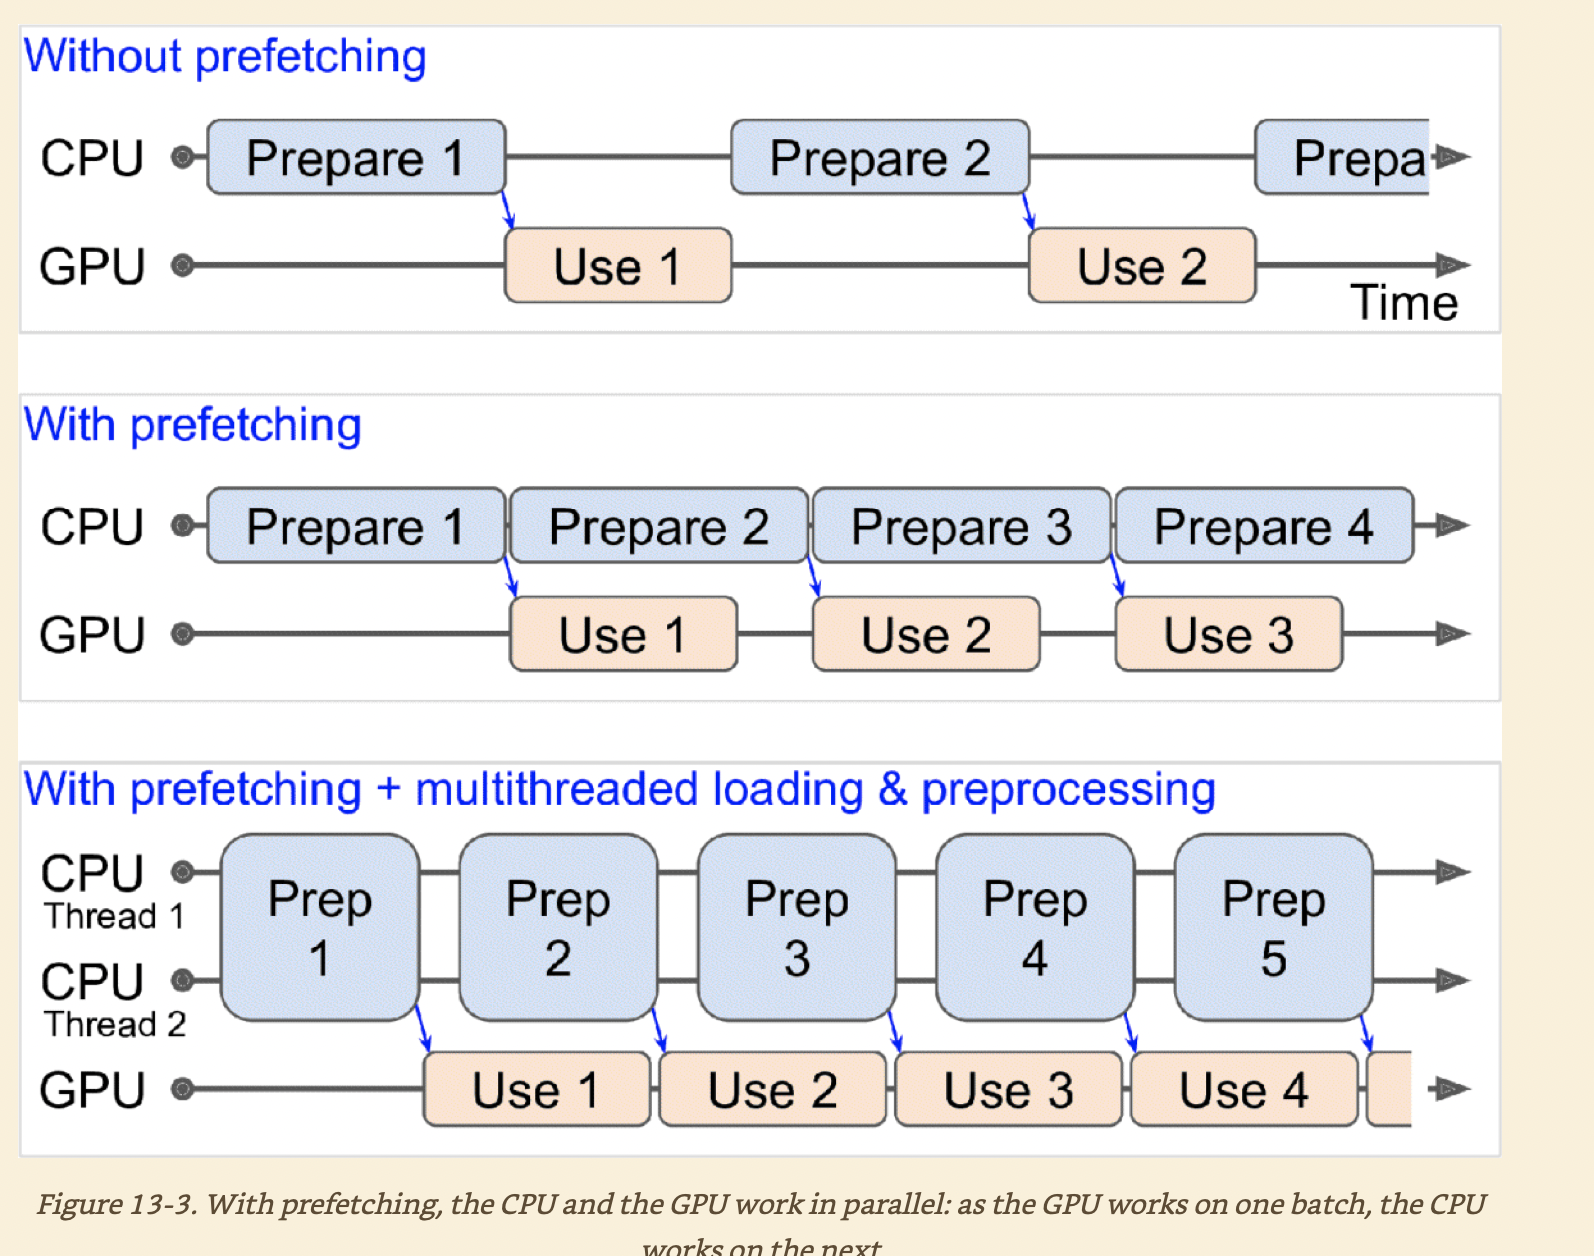

* **If the dataset is small enough to fit in memory, you can significantly speed up training by using the dataset's** cache( ) **method to cache its content to RAM**
    * **You should generally do this after loading and preprocessing the data, before shuffling, repeating, batching, and prefecthing.**

### Using the Dataset with tf.keras
* **We can use the** csv\_reader\_dataset( ) **custom function to create a dataset for the training set. Note that we do not need to repeat it, as this will be take care of by** tf.keras.

In [66]:
train_set = csv_reader_dataset(train_filepaths)

In [67]:
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

* **We can simply build and train a Keras model using these datasets. All we need to do is to pass the training and validation dataset to the** fit( ) **method, instead of** X\_train, y\_train, X\_valid, **and** y\_valid

In [ ]:
model = keras.models.Sequential([...])
model.compile([...])
model.fit(train_set, epochs=10, validation_data=valid_set)

**Similarly, we can pass a dataset to the** evaluate( ) **and** predict **method**

In [ ]:
model.evaluate(test_set)
new_set = test_set.take(3).map(lambda X, y: X) # pretend we have 3 new instances
model.predict(new_set)

**If you want to build your own custom traiing loop, you can just iterate over the traiing set**

In [ ]:
for X_batch, y_batch in train_set:
    [...] # perform one Gradient Descent stpe

**It is even possible to create a TF Function that perofrms the whole training loop**

In [ ]:
@tf.function
def train(model, optimizer, loss_fn, n_epochs, [...]):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs,[...])
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

## The TFRecord Format
* **The TFRecord format is TensorFlow's prefered format for stroing large amounts of data and reading it efficiently.**
* **It is a very simple binary format that just contains a sequence of binary records of varying sizes(each record is comprised of a length, a CRC checksum to check that the length was not corrupted, then the actual data, and finally a CRC checksum for the data).**
* **You can easily create a TFRecord file using the** tf.io.TFRecordWriter **class**

In [2]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this si the second record")

**And you can use a** tf.data.TFRecordDataset **to read one or more TFRecord files**
* **By default, a** TFRecordDataset **will read files one by one, but you can make it read multiple files in parallel and interleave their records by setting** num\_parallel\_reads 

In [3]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this si the second record', shape=(), dtype=string)


### Compressed TFRecord Files
* **You can creare a compressed TFRecord file by setting the** options **argument**

In [ ]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    [...]

**When read a compressed TFRecord file, you need to specify the compression type:**

In [ ]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"], 
                                 compression_type="GZIP")

### A Brief Introduction to Protocol Buffers


First let's write a simple protobuf definition:

In [4]:
%%writefile person.proto
syntax = "proto3"
message Person {
    string name = 1;
    int32 id = 2;
    repeat string email = 3;
}

Writing person.proto


And let's compile it (the `--descriptor_set_out` and `--include_imports` options are only required for the `tf.io.decode_proto()` example below):

In [5]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

zsh:1: command not found: protoc


In [6]:
!ls person*

person.proto


* **The definition says we are using version 3 of the protobuf format.**
* **Each** Person **object may have a name of type** string, **an** id **of type** int32, **and zero or more** email **fields, each of type** string.
* **The numbers** 1,2, **and** 3 **are the field ifentifiers: they will be used in each record's binary representation.**
* **Once you have a definition in a** .proto **file, you can compile it. This requires** protobuf **compiler, to generate access classes in Python.**

In [ ]:
form person_b2 import Person # import the generated access clss
person = Person(name="A1", id=123, email=["a@b.com"]) # create a Person
print(person)
person.name # read a field
person.email = "Alice" # modify a field
person.email[0] # repeated fields can be accessed like arrays
"a@b.com"
person.email.append("c@d.com") # add an email address
s = person.SerializeToString() # serialize the object to a byte string
person2 = Person()
person2.ParseFromString(s) # parse the byte string (27 bytes long)
person == person2 # now they are equal 

* **We import the** Person **class generated by** protoc, **we create an instance and play with it, visualizing it and reading and writing some fields, then we serialize it using the** SerializeToString( ) **method**
    * **When reading or receiving this binary data, we can parse it using the** ParseFromString( ) **method, and we get a copy of the object that was serialized.**

### TensorFlow Protobufs
* **The main protbuf typically used in a TFRecord file is the** Example **protobuf, which represents one instance in a dataset. It contains a list of named features, where each feature can either be a list of byte strings, a list of floats, or a list of integers.**

In [ ]:
syntax = "proto3"
message ByteList{ repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList byte_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example {Features features = 1; };

* \[packed = true\] **is used or repeated numerical fiedls, for a more efficient encoding.**
* **A** Feature **contains either a** BytesList, **a** FloatList, **or an** Int64List
* **A** Features **contains a dictinary that maps a feature name to the corresponding feature value.**
* **An** Example **contains a** Features **object.**

**Creating a** tf.train.Example **representing the a person and write it to a TFRecord File**

In [9]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

In [10]:
person_example = Example(features=Features(feature={
    "name" : Feature(bytes_list=BytesList(value=[b"Alice"])),
    "id" : Feature(int64_list=Int64List(value=[123])),
    "emails" : Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
}))

**Once we have an** Example **protobuf, we can serialize it by calling its** SerializeToString( ) **method, then write the resuting data to a TFRecord file**

In [11]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

### Loading and Parsing Examples
* **To load the serialized** Example **protobufs, we will use a** tf.data.TFRecordDataset **onceagain, and we will parse each** Example **using** tf.io.parse_single_example( )
    * **This function requires at least two arguments: a string scalar tensor containing the serialized data, and a description of each feature.**
* **The description is a dictionary that maps each feature name to either a** tf.io.FixedLenFeature **descriptor indicating the feature's shape, type, and default value, or a** tf.io.VarLenFeature **descriptor indicating only the type**

**Defines a decription dictionary, then it iterates over the** TFRecordDataset **and parses the serialized** Example **protobuf this dataset contains.**

In [12]:
feature_description = {
    "name" : tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id" : tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "email" : tf.io.VarLenFeature(tf.string),
}

In [13]:
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)

* **The fixed-length features are parsed as regular tensors, but the variable-length features are parsed as sparse tensors.**
* **You can convert a sparse tensor to a densor tensor using** tf.sparse.to\_dense( )

In [15]:
parsed_example

{'email': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f8bcc477070>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [16]:
tf.sparse.to_dense(parsed_example["email"], default_value=b"")

<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>

In [17]:
parsed_example["email"].values

<tf.Tensor: shape=(0,), dtype=string, numpy=array([], dtype=object)>

**Instead of parsing examples by one using** tf.io.parse_single_example( ), **you may want to parse them batch by batch using** tf.io.parse_example( )

In [18]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples, feature_description)

In [19]:
parsed_examples

{'email': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f8bcc47b400>,
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123])>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

### Handling Lists of Lists Using the SequencExample Protobuf

**Definition of the** SequenceExample **protobuf**

In [ ]:
message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; }
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
}

* **A** SequenceExample **contains a** Features **object for the contextual data and a** FeatureLists **object that contains one or more named** FeatureList **objects(e.g., a** FeatureList **named** "content" **nd another named** "comments".)
* **Each** FeatureList **contains a list of** Feature **objects, each of which may be a lsit of byte strings, a list of 64-bit integers, or a list of floats.**
* **Buidling a** SequenceExample, **serializing it, and parsing it is similar to building, serializing, and parsing an** Example, **but you must use** tf.io.parse_single_sequence_exmample( ) **to parse a single** SequenceExample **or** tf.io.parse_sequence_example( ) **to parse a batch**
* **If the feature lists contain sequences of varying sizes, you may want to convert them to ragged tensors, using** tf.RaggedTensor.from\_sparse( )

In [ ]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
serialized_sequence_example, context_feature_descriptions,
sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])

## Preprocessing the Input Features
* **You can preprocess your data on the fly when loading it with the Data APIusing the dataset's** map( ) **method), or you can include a preprocessing layer directly in your model.**

**Implement a standardization layer using a** Lambda **layer. For each feature, it subtracts the mean and divides by its standard deviation(plus a smoothing term to avoid division by zero).**

In [ ]:
means = np.mean(X_train, axis=0, keepdims=True)
stds = np.std(X_train, axis=0, keepdims=True)
eps =keras.backend.epsilon()
model = keras.models.Sequential([
    keras.layers.Lambda(lambda inputs: (inputs - means) / (stds + eps))
    [...] # other layers
])

**Creating a self-contained custom layer, rather than having gloobal variables like** means **and** stds **dangling around**

In [21]:
class Standardizaion(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon)
    keras.backend.epsilon()

* **Before you can use this standardization layer, you will need to adapt it to your dataset by calling the** adapt( ) **method and passing it a data sample.**
* **This will allow it to use the appropriate mean and standard deviatio for each feature.**

In [ ]:
std_layer = Standardizaion()
std_layer.adapt(data_sample)

**Next, you can use this preprocessing layer like a normal layer**

In [ ]:
model = keras.Sequential()
model.add(std_layer)
[...] # create the rest of the model
model.compile([...])
model.fit([...])

### Encoding Categoriccal Features Using One-Hot Vectors
* **Map each category to its index(0 to 4), which can be done using a look up table.**

In [23]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

* **Define the *vocabulary*: this is the list of all possible categories.**
* **Create a tensor with the corresponding indices(0 to 4)**
* **Create an intialize for the lookup table, passing it the list of categoriesand their corresponding indices.**
* **In the last two lines we create the lookup table, giving it the initializer and specifying the number of *out-of-vocabulary(oov)* buckets. If we look up a category that does not exist in the vocbulary, the lookup table will compute a has of this category and use it to assign the unknown category to one of the oov buckers. Thier indices start after the known categories.**
* **The more unknown categories you expect to find during training, the more oov buckets you should use.**

**Use the lookup table to encode a small batch of categorical features to one-hot vectors.**

In [24]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [25]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)

In [26]:
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

* tf.one\_hot( ) **to one-hot encode these indices. We have to tell this function the total number of indices, which is equal to the vocabulary size plus the number of oov buckets.**
* **As a rule of thumb,  if the number of categories is lower than 10, then one-hot encoding is generally the way to go.**
* **If the number of categories is greater than 50, then embeddings are usually preferable.**

### Encoding Categorical Featyures Using Embeddings
* **An embedding is a trainable dense vector that represents a category.**
* **Representational learning: By default, embeddings are intialized randomly. Training tends to make embeddings useful representations of the categories.**
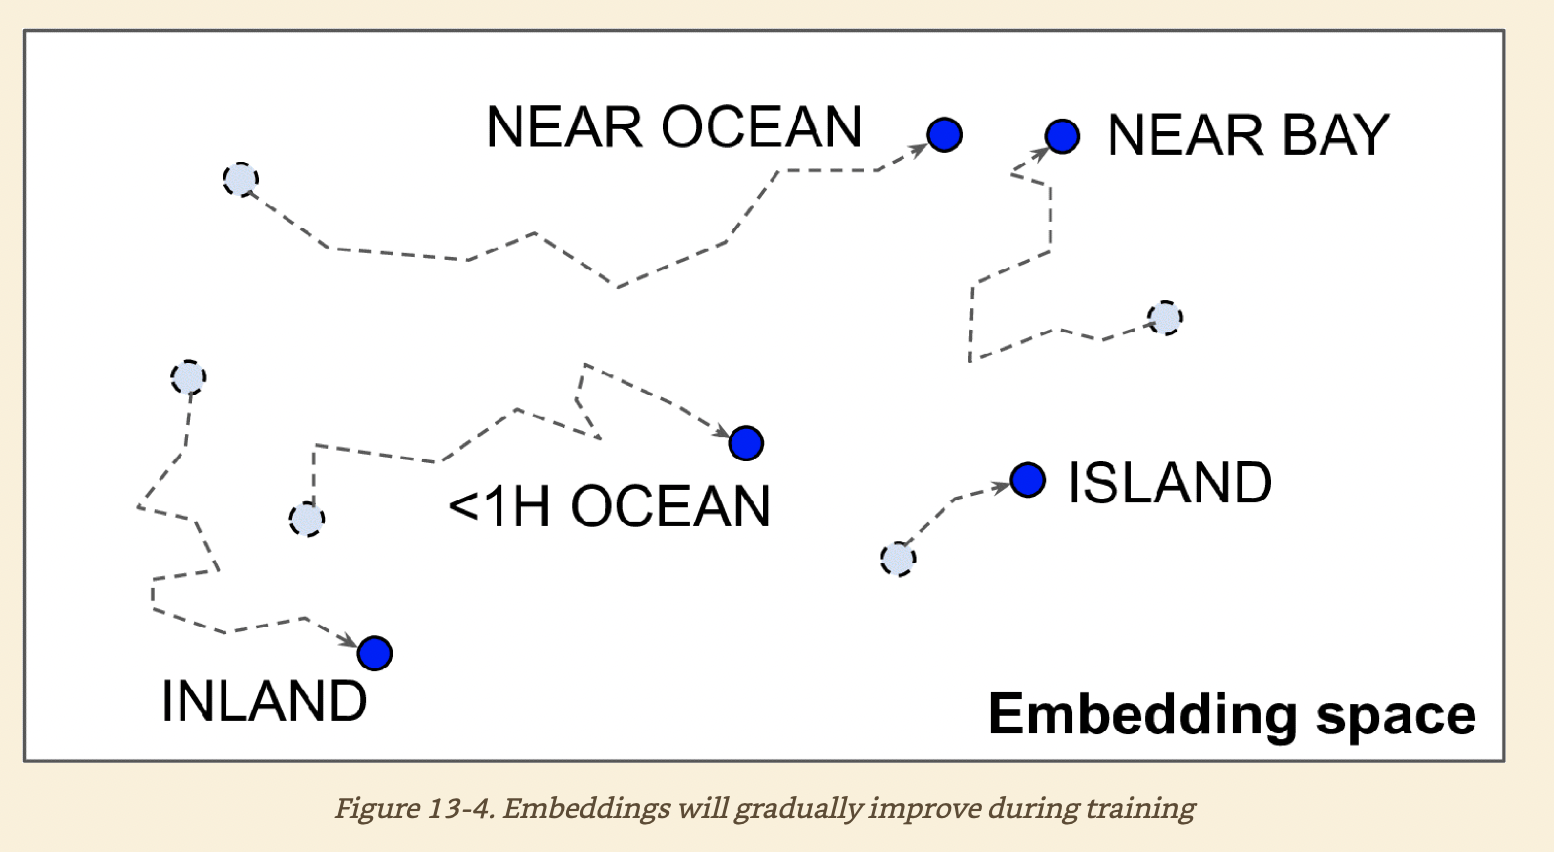



**Create an *embedding matrix* conataining each category's emedding, intialized radomly; it will hae one row per category and per oov bucker, and one column per embeddin dimension:**

In [27]:
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init)

**This embedding matrix is a random 6 x 2, stored in a variale(so it can be tweaked by Gradient Descent during training):**

In [28]:
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.49747193, 0.56788325],
       [0.9980675 , 0.87692773],
       [0.46144927, 0.7750131 ],
       [0.5658088 , 0.63674784],
       [0.9701736 , 0.23697996],
       [0.48804903, 0.491292  ],
       [0.61626184, 0.26329505]], dtype=float32)>

**Encode Categorical features using embedding**
* **The** tf.nn.embedding\_lookup( ) **function looks up the rows in the embedding matrix, at the given indices.**

In [29]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [30]:
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.5658088 , 0.63674784],
       [0.48804903, 0.491292  ],
       [0.9980675 , 0.87692773],
       [0.9980675 , 0.87692773]], dtype=float32)>

**Keras provies a** keras.layers.Embedding **layer that handle the embedding matrix(trainable, by default); when the layer is created it intializes the embedding matrix randomly, and then when it is called with some category ndices it returns the rows at those indicws in the embedding matrix:**

In [32]:
embedding = keras.layers.Embedding(input_dim=len(vocab) + num_oov_buckets,
                                  output_dim=embedding_dim)

In [33]:
embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.03654869,  0.03300914],
       [ 0.00690659, -0.01127511],
       [ 0.04081241, -0.03191339],
       [ 0.04081241, -0.03191339]], dtype=float32)>

**Creating a Keras model that can process categorical features(along with regular numerical features) and learn an embedding for each category(as well as for each oov bucker)**

In [36]:
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)
encode_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encode_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories],
                          outputs=[outputs])

* **This model takes two inputs: a regular input contaiing eight numerical features per instance, plus a categorical input(containing one categorical feature per instacne).**
* **This model uses a** Lambda **layer to look up each category's index, then it looks up the embeddings for these indices.**
* **Next, it concatenates the embeddings and the regular inputs in order to give the encoded inputs, which are ready t be fed to a neural network.**
* **Add a dense output layer, and we create the Keras model.**

**One-hot encoding followed by a** Dense **layer(with no activation function and no biases) is equivalent to an** Embedding **layer**

### Keras Preprocessing Layers

* keras.layers.experimental.preprocessing.Normalization **will perform feature standardization(it will be equivalent to the** Standardization **layer we defined earlier)**
* keras.layers.experimental.TextVectorization **layer will be capable to encoding each word in the inputs into its index in the vocabulary**
* keras.layers.Discretization **layer will chop continuous data into different bins and enocde each bin as a one-hot vector**
* **It is also possible to chain multiple preprocessing layer using the** PreprocessingStage **class*

**The following code will create a preprocessing pipeline that will first normalize the inputs, then discretize them**

In [ ]:
normalization = keras.layers.preprocessing.Normalization()
discretization = keras.layers.experimental.preprocessing.Discretization([...])
pipeline = keras.layers.PreprocessingStage([normalization, discretization])
pipeline.adapt(data_sample)

**The** TextVectorization **layer will also have an option to output word-count instead of word indices**<br>
* **Word counts should be normalized in a way that reduces the importance of frequent words.**
    * **This is ofen done using a technique called *Term-Frequency x Inverse-Document-Frequency* (TF-IDF)**

## The TensorFlow Datasets(TFDS) Project
* **The TensorFLow Datasets project makes it very easy to download common datasets.**
* **The TFDS is not bundled with TensorFlow, so you need to instal the** tensoflow-datasets **library(e.g., using pip), then call the** tfds.load( ) **function, and it will downlod the data you want and return the data as a dictionary of datasets(typically one for training and one for testing)**
* **For a full list of the datasets,** [click here](https://www.tensorflow.org/datasets/catalog/overview)

In [40]:
import tensorflow_datasets as tfds

In [43]:
dataset = tfds.load(name="mnist")



Dataset mnist downloaded and prepared to /Users/linghao/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [46]:
mnist_train, mnist_test = dataset["train"], dataset["test"]

**You can then apply any transformation you want(typically shuffling, batching, and prefetching), and you're ready to train you model**

In [48]:
mnist_train = mnist_train.shuffle(10000).batch(32).prefetch(1)

In [ ]:
for item in mnist_train:
    images = item["image"]
    labels = items["label"]
    [...]

**Since each item in the dataset is a dictionary containing both the features and the lables, but Keras expect each item to be a tuple containing two elements(the features and the labels), you could transform the dataset using the** map( ) **method**

In [49]:
mnist_train = mnist_train.shuffle(10000).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

* **It'simpler to ask the** load( ) **function to do this for you by setting** as\_supervised=True 
* **You can specify the batch size if you want to**

In [ ]:
dataset = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = dataset["train"].prefetch(1)
model = keras.models.Sequential([...])
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd")
model.fit(mnist_train, epochs=5)